# Домашнее задание 5. Градиентный спуск. (10 баллов + 2.5 бонус)

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

In [214]:
from typing import Iterable, List


import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [215]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [216]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        return np.square(X.dot(w) - y).mean()

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        return (np.dot(X.T, (np.dot(X, w) - y))) / (y.shape[0]) * 2

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [217]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [218]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = w_init.copy()
    w_list = [w.copy()]
    for _ in range(n_iterations):
        w -= lr * loss.calc_grad(X, y, w)
        w_list.append(w.copy())
    return np.array(w_list)  

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [219]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [220]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
0.8670644395649493


In [221]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

Learning Rate: 0.0001
Current Loss Function Value: 7.07853675658905


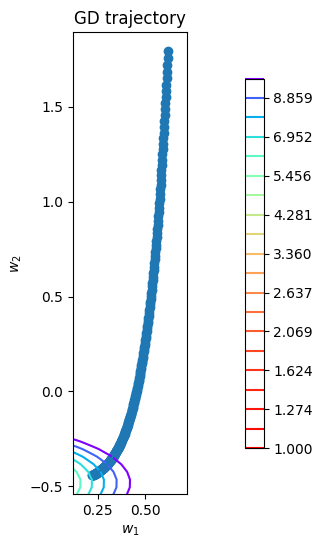

Learning Rate: 0.00026826957952797245
Current Loss Function Value: 2.52616218831192


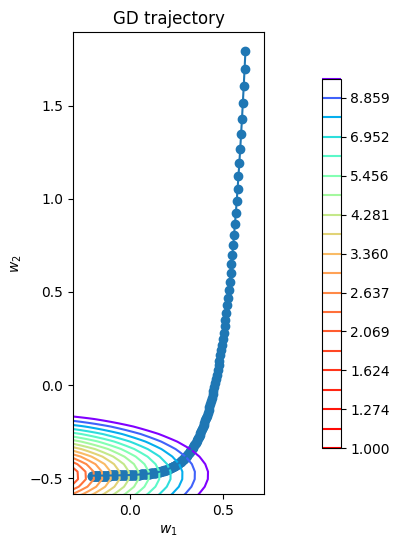

Learning Rate: 0.0007196856730011522
Current Loss Function Value: 0.9171727658178587


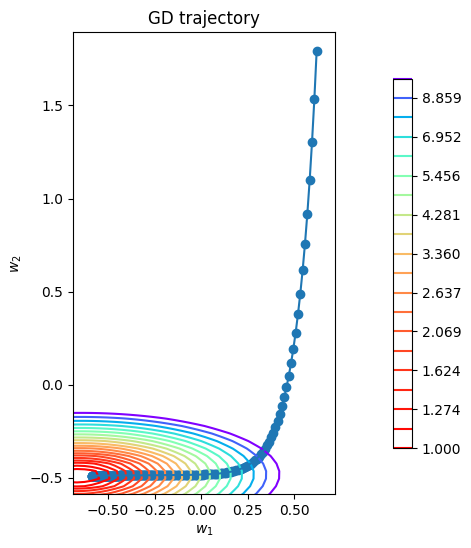

Learning Rate: 0.0019306977288832496
Current Loss Function Value: 0.8670681460722551


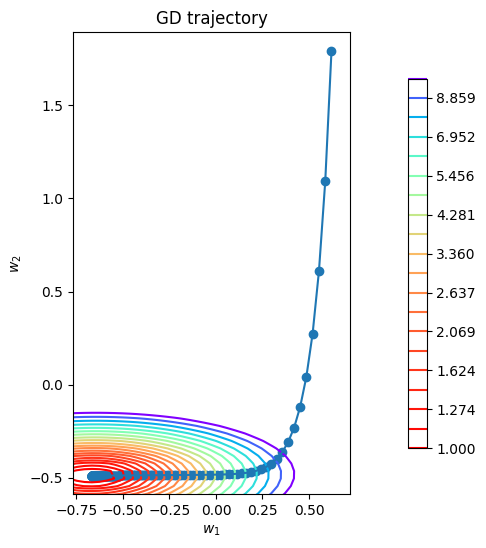

Learning Rate: 0.005179474679231213
Current Loss Function Value: 0.8670644395649091


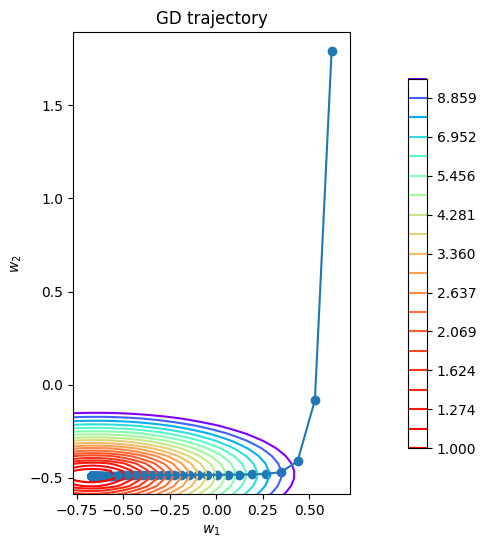

Learning Rate: 0.013894954943731374
Current Loss Function Value: 5.769135422691064e+44


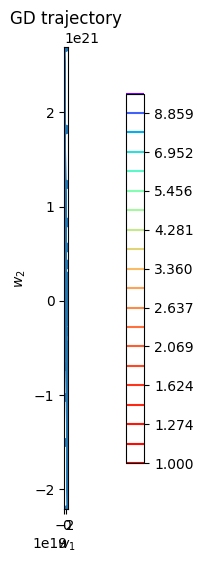

C:\Users\79603\AppData\Local\Temp\ipykernel_17696\4004012864.py:11: RuntimeWarning: overflow encountered in square
  return np.square(X.dot(w) - y).mean()


Learning Rate: 0.03727593720314938
Current Loss Function Value: inf


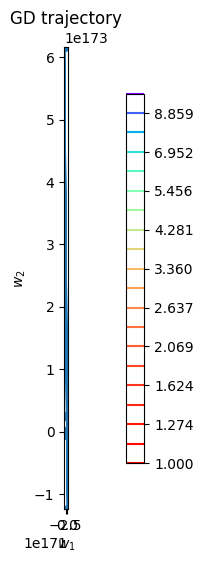

Learning Rate: 0.1
Current Loss Function Value: inf


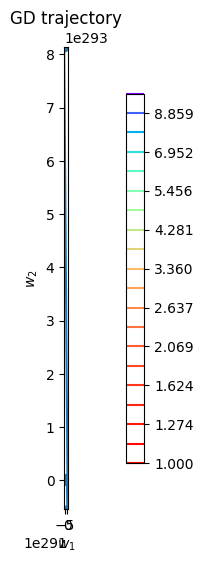

Best Learning Rate: 0.005179474679231213


In [222]:
learning_rate_array = np.geomspace(0.0001, 0.1, num=8) # returns a geometric progression
min_loss = np.inf

for step in learning_rate_array:
    w_list = gradient_descent(w_init, X, y, loss, lr=step, n_iterations=250)
    cur_loss = loss.calc_loss(X, y, w_list[-1])
    
    # Именно в w_list[-1] мы должны быть ближе всего к локальному минимуму, 
    # если всё пойдёт по плану
    
    print(f'Learning Rate: {step}\nCurrent Loss Function Value: {cur_loss}')
    
    if cur_loss < min_loss:
        best_learn_rate, min_loss = step, cur_loss
    
    plot_gd(w_list, X, y, loss)
print(f'Best Learning Rate: {best_learn_rate}')

На первых 2 графиках из-за маленького шага так и не получилось достичь локального минимума. Конечно, можно было бы изменить количество итераций в большую сторону, но это бы потребовало больше времени и вычислительных ресурсов. Целесообразнее в данном случае увеличивать количество шагов. На следующих графиках видим, как мы приближаемся всё сильнее к минимуму, оптимальным вариантом в итоге оказался шаг 5 с минимальным значением функции потерь. 4 шаг минимально отличается от него, но предпочтём всё-таки 5. Далее шаг становится слишком большим и функция перескакивает через локальный минимум. 

Теперь реализуем стохастический градиентный спуск

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [223]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = w_init.copy()
    w_list = [w.copy()]
    batch_ind = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch, batch_y = X[batch_ind], y[batch_ind]
    for i in range(n_iterations):
        w -= lr * loss.calc_grad(batch, batch_y, w)
        w_list.append(w.copy())
    return np.array(w_list)

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

Learning Rate: 0.0001
Batch Size: 1
Current Loss Function Value: 352.27402062342384


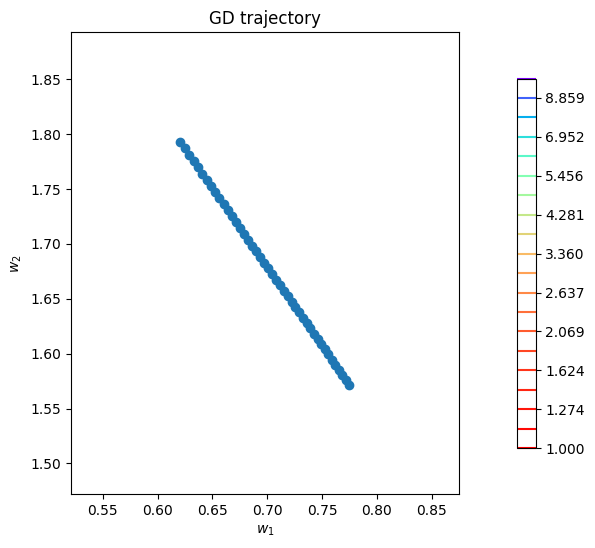

Learning Rate: 0.0001
Batch Size: 43
Current Loss Function Value: 113.49420882589662


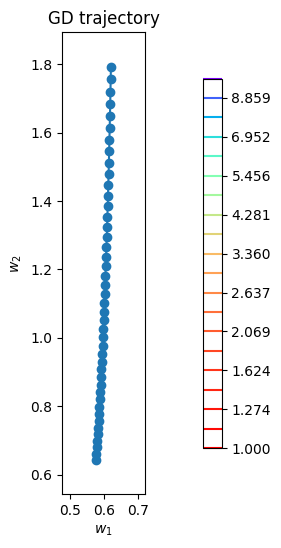

Learning Rate: 0.0001
Batch Size: 86
Current Loss Function Value: 127.95569123244776


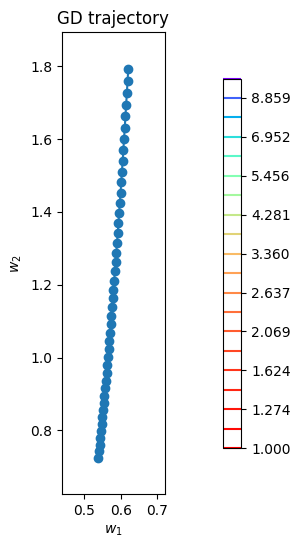

Learning Rate: 0.0001
Batch Size: 129
Current Loss Function Value: 108.63678184465174


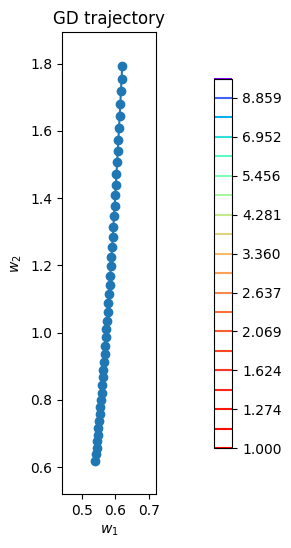

Learning Rate: 0.0001
Batch Size: 171
Current Loss Function Value: 115.49962181643748


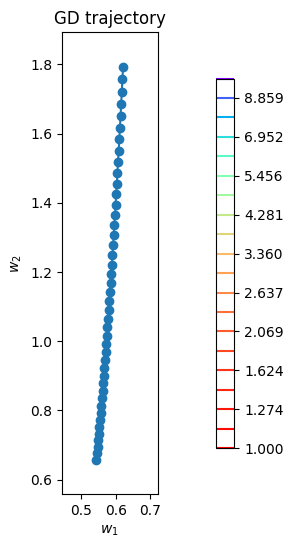

Learning Rate: 0.0001
Batch Size: 214
Current Loss Function Value: 113.14700930225399


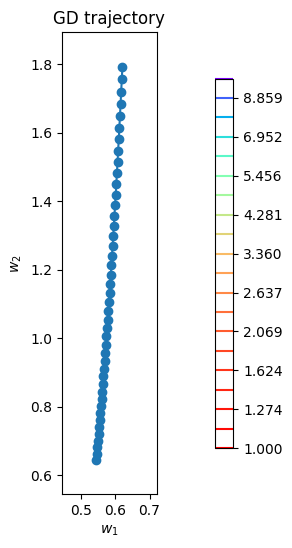

Learning Rate: 0.0001
Batch Size: 257
Current Loss Function Value: 113.97421980503476


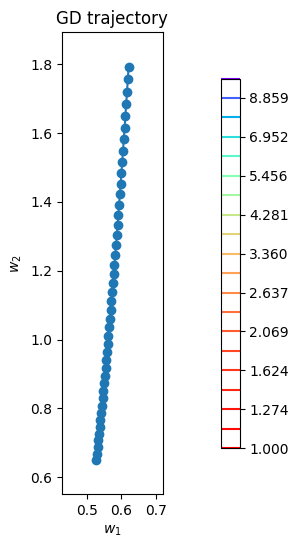

Learning Rate: 0.0001
Batch Size: 300
Current Loss Function Value: 115.76116928160981


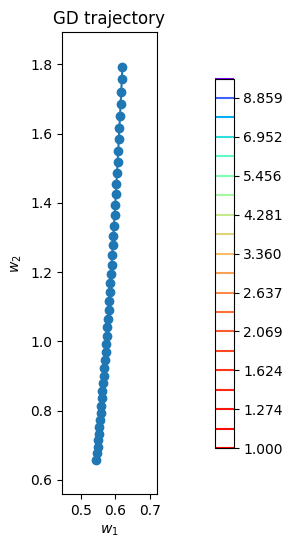

Learning Rate: 0.00026826957952797245
Batch Size: 1
Current Loss Function Value: 101.55043805693164


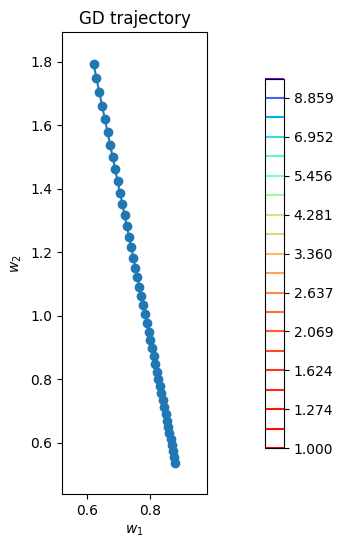

Learning Rate: 0.00026826957952797245
Batch Size: 43
Current Loss Function Value: 21.97198178442228


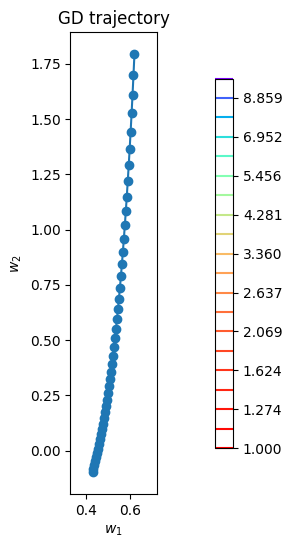

Learning Rate: 0.00026826957952797245
Batch Size: 86
Current Loss Function Value: 20.84641595415609


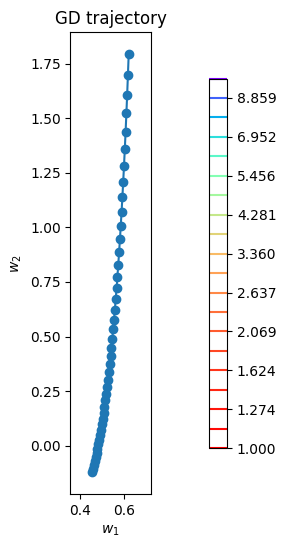

Learning Rate: 0.00026826957952797245
Batch Size: 129
Current Loss Function Value: 16.83485984543095


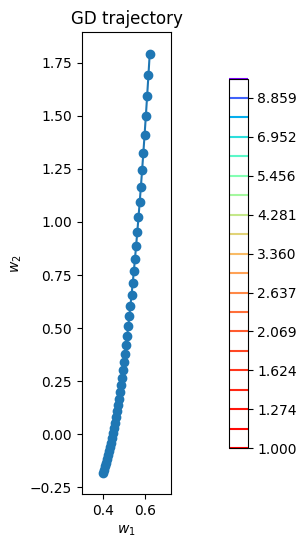

Learning Rate: 0.00026826957952797245
Batch Size: 171
Current Loss Function Value: 19.15757140855898


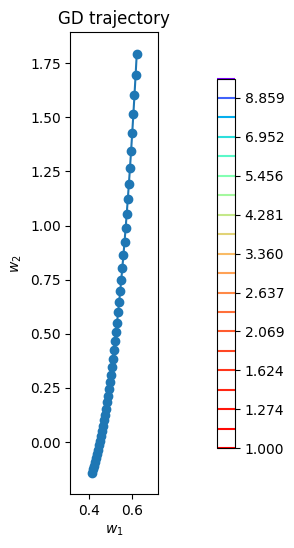

Learning Rate: 0.00026826957952797245
Batch Size: 214
Current Loss Function Value: 20.57514472149581


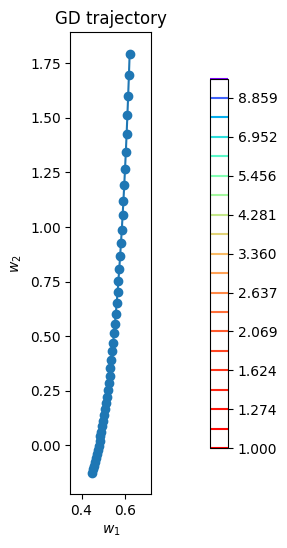

Learning Rate: 0.00026826957952797245
Batch Size: 257
Current Loss Function Value: 19.66993333739022


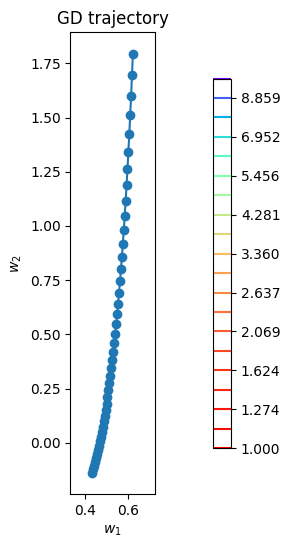

Learning Rate: 0.00026826957952797245
Batch Size: 300
Current Loss Function Value: 19.672741373109965


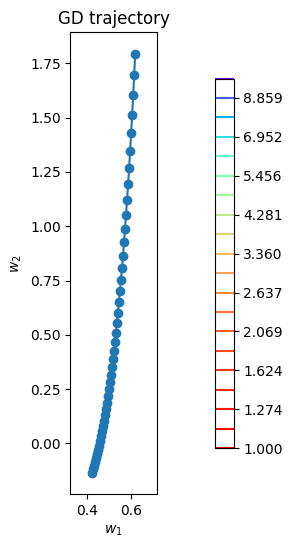

Learning Rate: 0.0007196856730011522
Batch Size: 1
Current Loss Function Value: 11.896718866040162


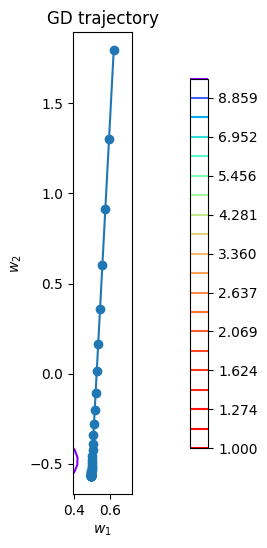

Learning Rate: 0.0007196856730011522
Batch Size: 43
Current Loss Function Value: 4.454063667913025


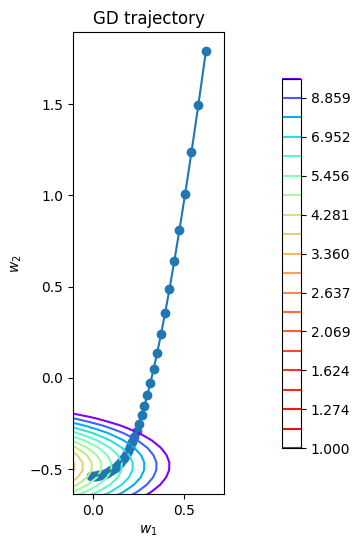

Learning Rate: 0.0007196856730011522
Batch Size: 86
Current Loss Function Value: 5.561219953223448


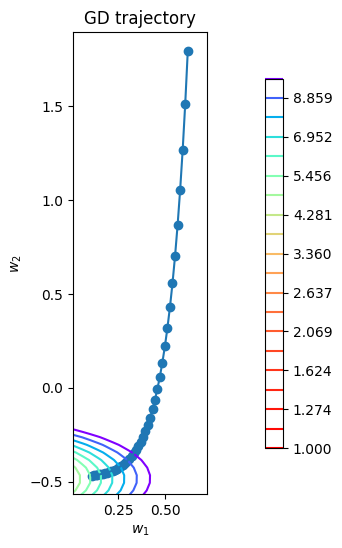

Learning Rate: 0.0007196856730011522
Batch Size: 129
Current Loss Function Value: 6.121613328696074


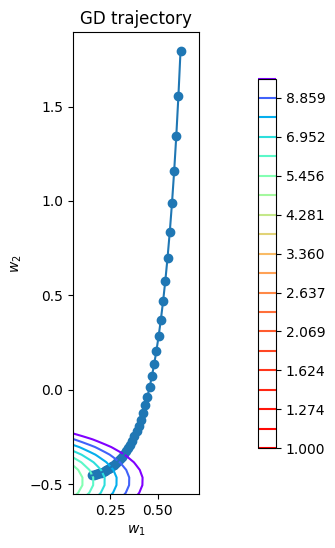

Learning Rate: 0.0007196856730011522
Batch Size: 171
Current Loss Function Value: 6.172549350505549


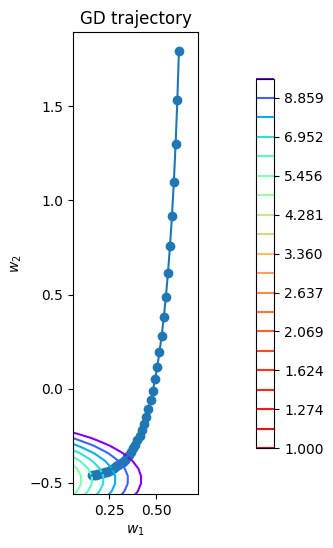

Learning Rate: 0.0007196856730011522
Batch Size: 214
Current Loss Function Value: 5.939769701012988


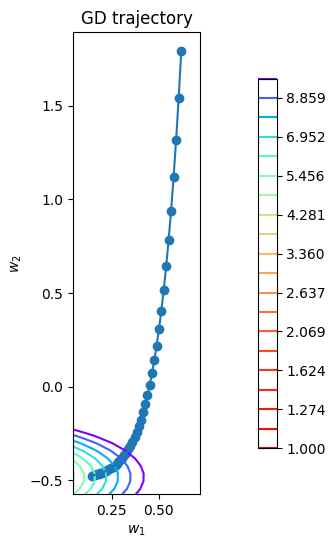

Learning Rate: 0.0007196856730011522
Batch Size: 257
Current Loss Function Value: 6.4131529910219145


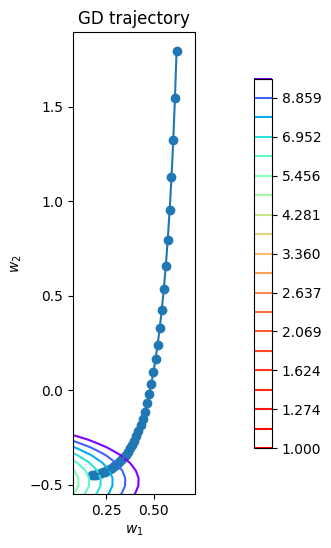

Learning Rate: 0.0007196856730011522
Batch Size: 300
Current Loss Function Value: 5.91612295640754


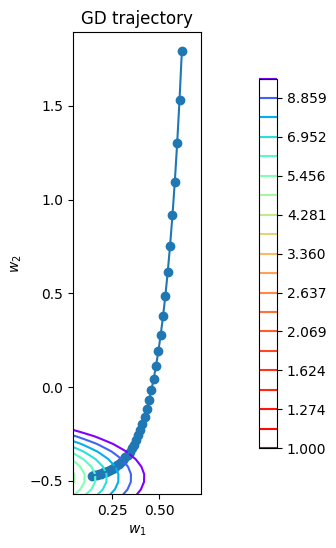

Learning Rate: 0.0019306977288832496
Batch Size: 1
Current Loss Function Value: 478.1653213807609


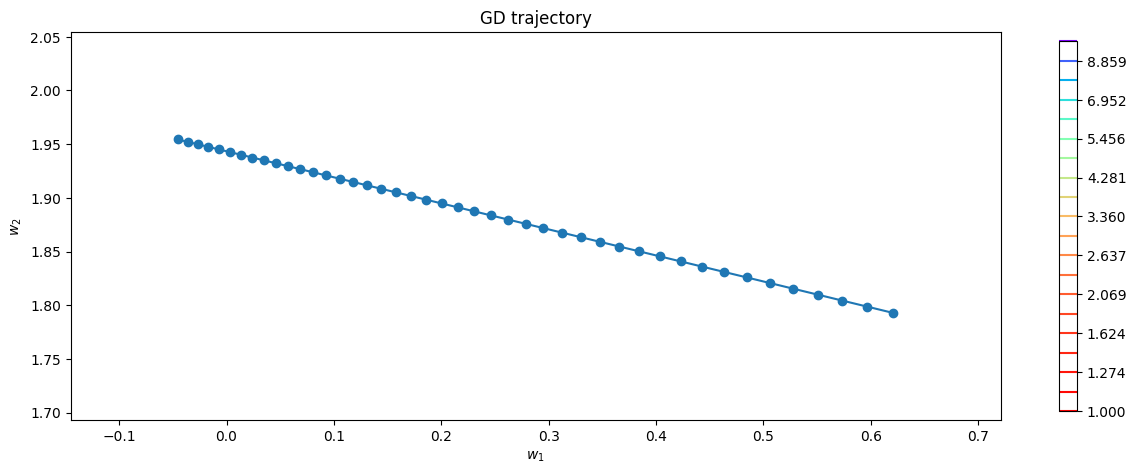

Learning Rate: 0.0019306977288832496
Batch Size: 43
Current Loss Function Value: 2.3499479046617435


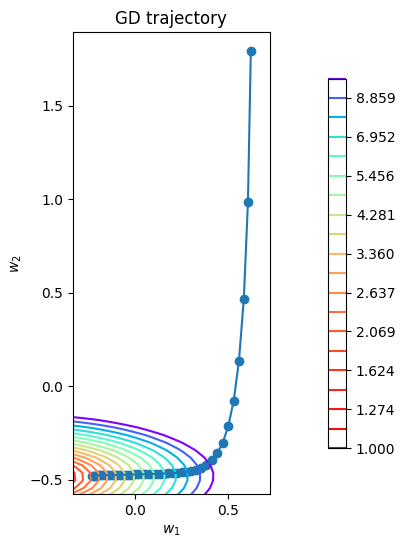

Learning Rate: 0.0019306977288832496
Batch Size: 86
Current Loss Function Value: 1.7443003174366791


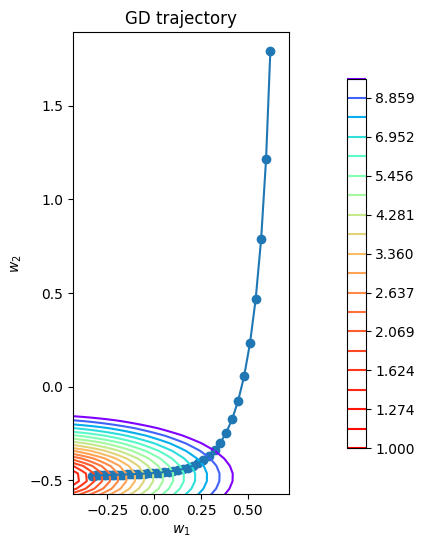

Learning Rate: 0.0019306977288832496
Batch Size: 129
Current Loss Function Value: 1.6151679764201643


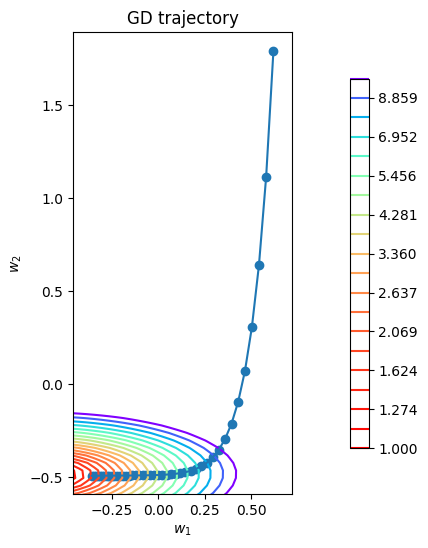

Learning Rate: 0.0019306977288832496
Batch Size: 171
Current Loss Function Value: 2.111470767261081


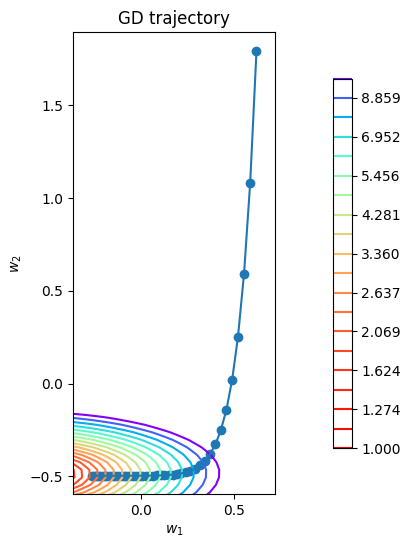

Learning Rate: 0.0019306977288832496
Batch Size: 214
Current Loss Function Value: 1.9698839070059444


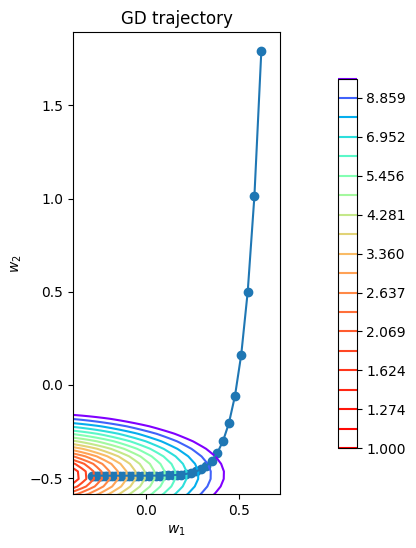

Learning Rate: 0.0019306977288832496
Batch Size: 257
Current Loss Function Value: 1.772390707030604


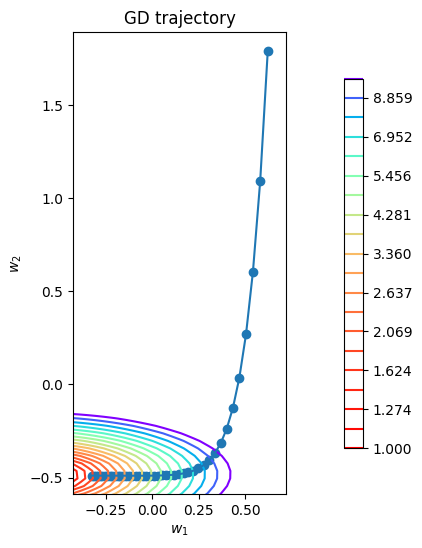

Learning Rate: 0.0019306977288832496
Batch Size: 300
Current Loss Function Value: 1.8481071062555907


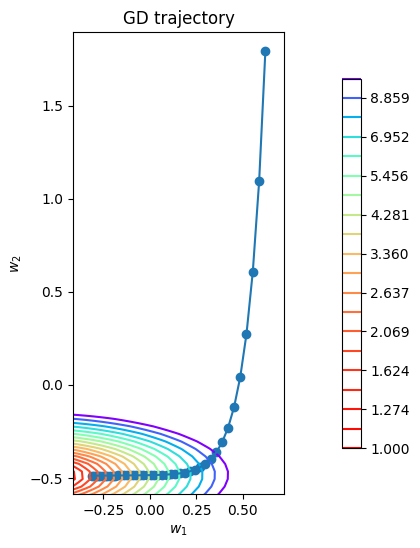

Learning Rate: 0.005179474679231213
Batch Size: 1
Current Loss Function Value: 10.168916799385476


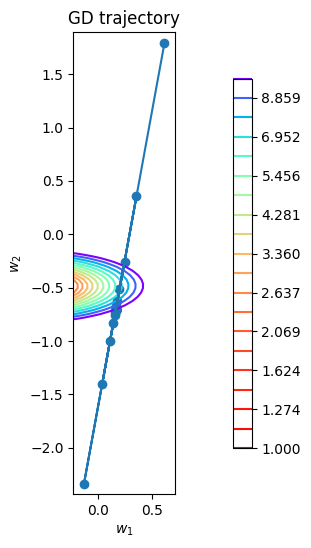

Learning Rate: 0.005179474679231213
Batch Size: 43
Current Loss Function Value: 1.0703519430306028


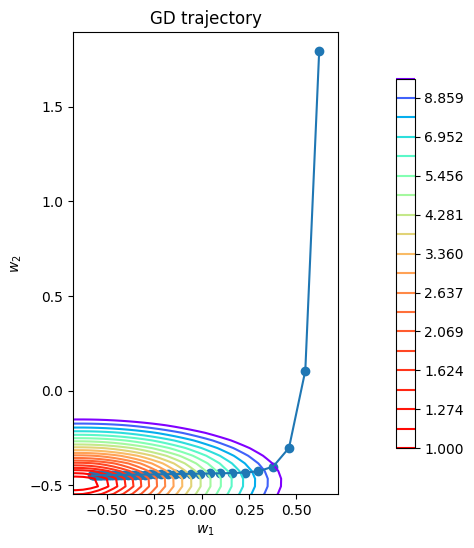

Learning Rate: 0.005179474679231213
Batch Size: 86
Current Loss Function Value: 0.877334037218878


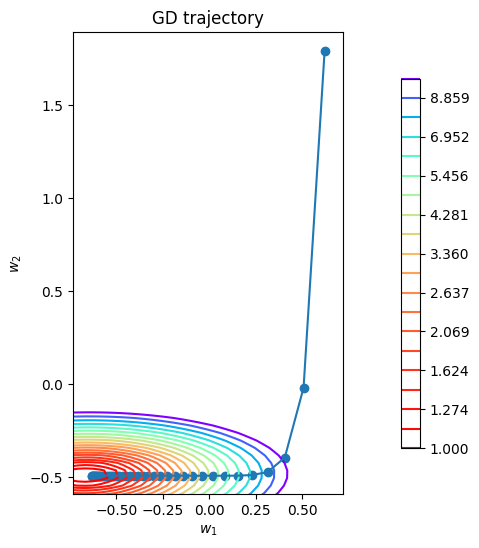

Learning Rate: 0.005179474679231213
Batch Size: 129
Current Loss Function Value: 0.8942516608283814


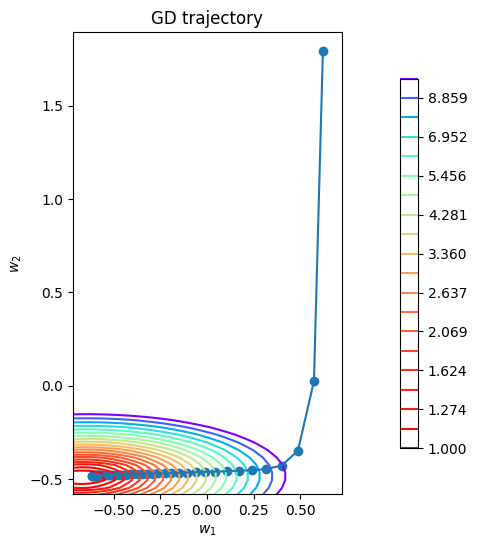

Learning Rate: 0.005179474679231213
Batch Size: 171
Current Loss Function Value: 0.8713615396736472


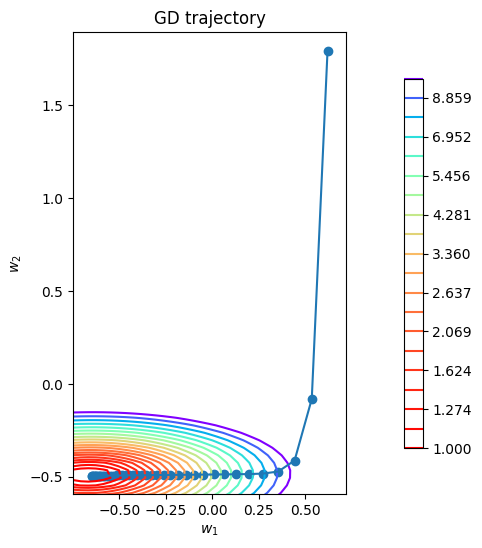

Learning Rate: 0.005179474679231213
Batch Size: 214
Current Loss Function Value: 0.8848643438846019


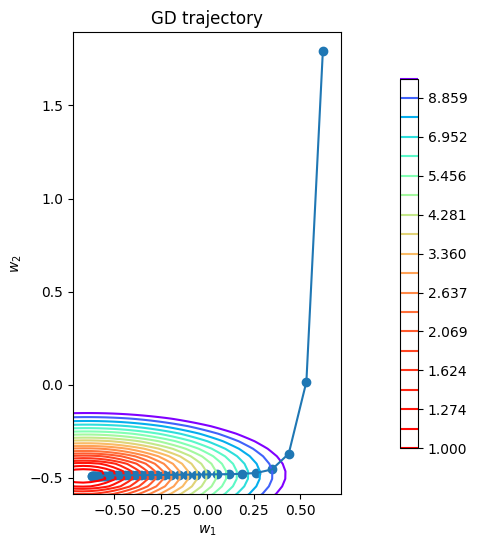

Learning Rate: 0.005179474679231213
Batch Size: 257
Current Loss Function Value: 0.8714649425582265


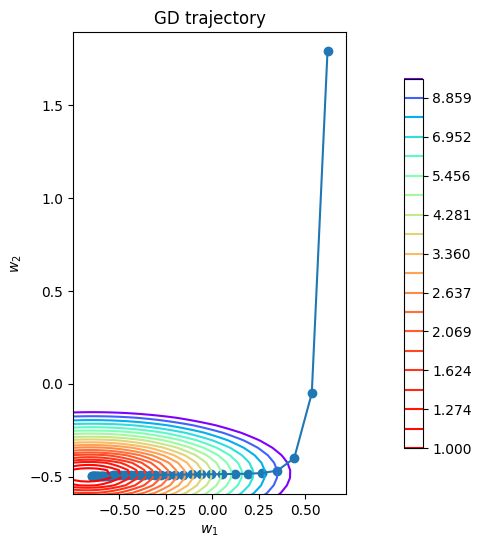

Learning Rate: 0.005179474679231213
Batch Size: 300
Current Loss Function Value: 0.8774392359337374


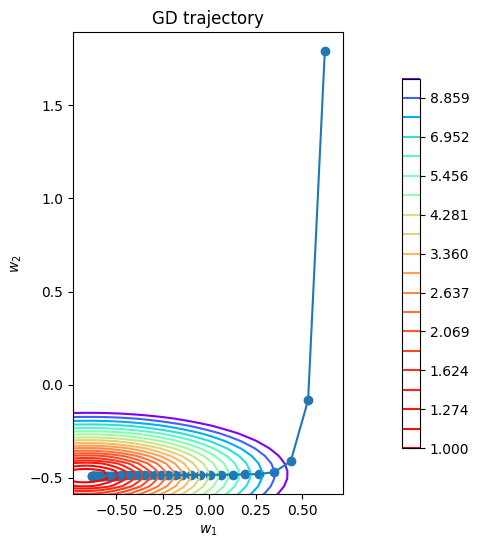

Learning Rate: 0.013894954943731374
Batch Size: 1
Current Loss Function Value: 275.18104833432966


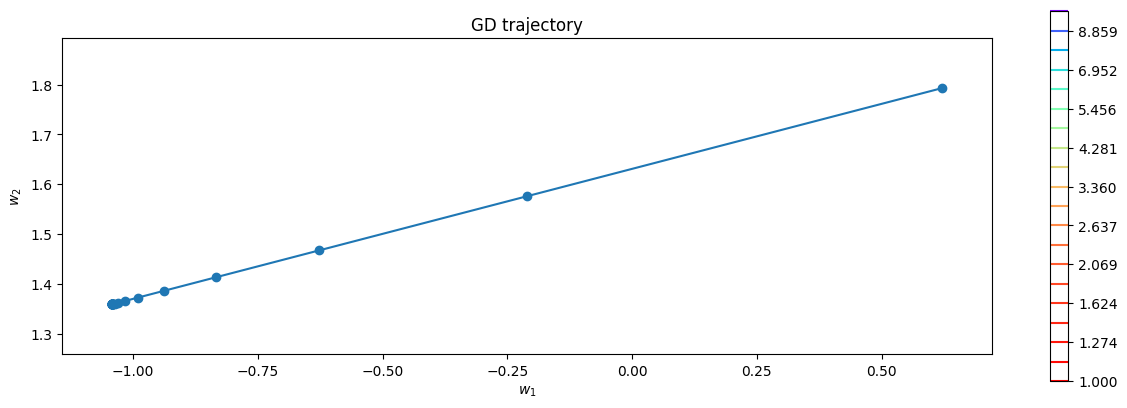

Learning Rate: 0.013894954943731374
Batch Size: 43
Current Loss Function Value: 10.386955304569002


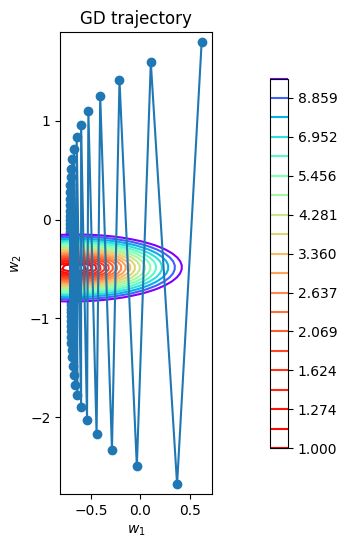

Learning Rate: 0.013894954943731374
Batch Size: 86
Current Loss Function Value: 23984.25839402173


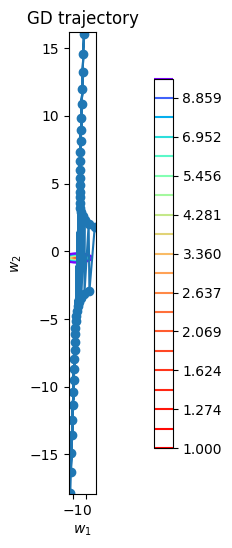

Learning Rate: 0.013894954943731374
Batch Size: 129
Current Loss Function Value: 59071422686.59963


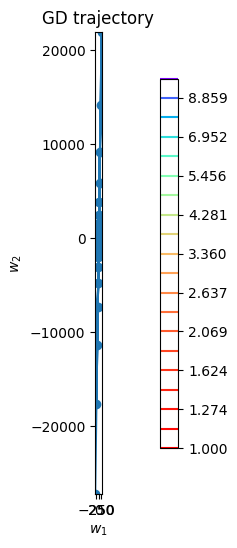

Learning Rate: 0.013894954943731374
Batch Size: 171
Current Loss Function Value: 210865041.68171835


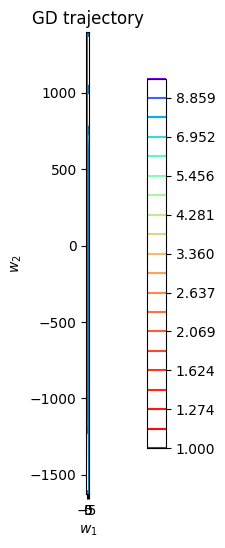

Learning Rate: 0.013894954943731374
Batch Size: 214
Current Loss Function Value: 157231.5731149729


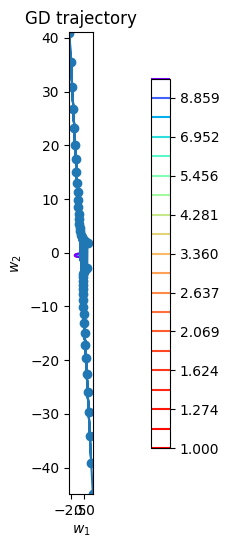

Learning Rate: 0.013894954943731374
Batch Size: 257
Current Loss Function Value: 61340630777.1596


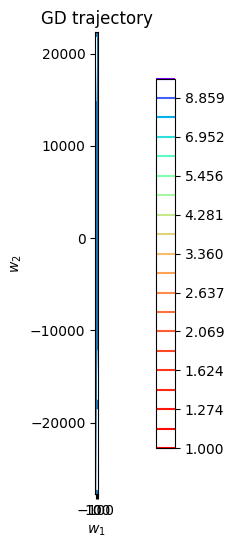

Learning Rate: 0.013894954943731374
Batch Size: 300
Current Loss Function Value: 7306221934.496995


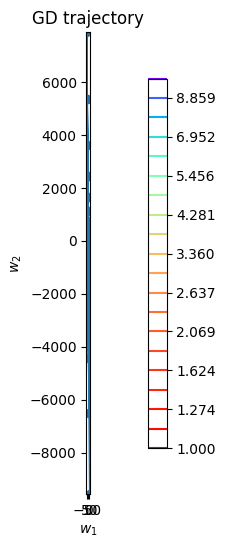

Learning Rate: 0.03727593720314938
Batch Size: 1
Current Loss Function Value: 2.5235383134695476e+73


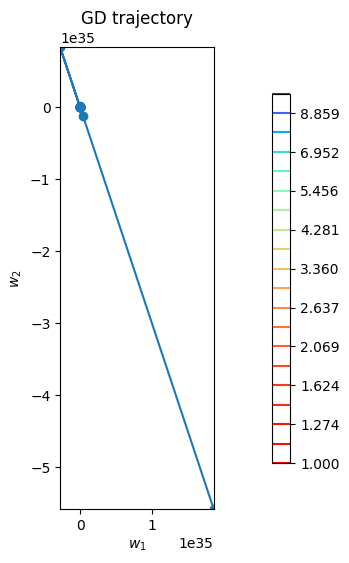

Learning Rate: 0.03727593720314938
Batch Size: 43
Current Loss Function Value: 1.593964705923901e+62


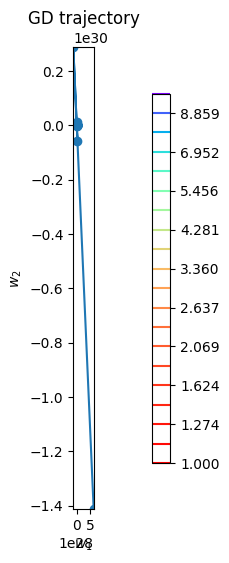

Learning Rate: 0.03727593720314938
Batch Size: 86
Current Loss Function Value: 8.890326130675117e+58


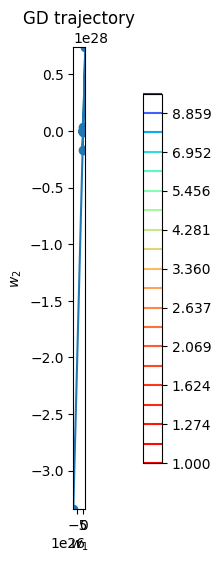

Learning Rate: 0.03727593720314938
Batch Size: 129
Current Loss Function Value: 9.630623915925192e+62


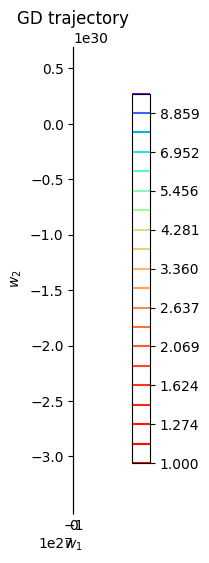

Learning Rate: 0.03727593720314938
Batch Size: 171
Current Loss Function Value: 4.6773891229245005e+62


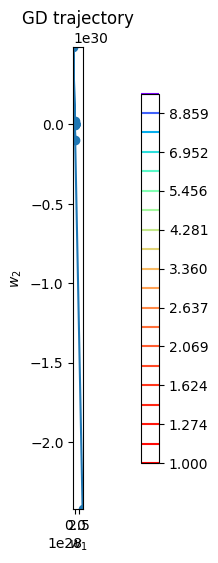

Learning Rate: 0.03727593720314938
Batch Size: 214
Current Loss Function Value: 1.0693329332536333e+62


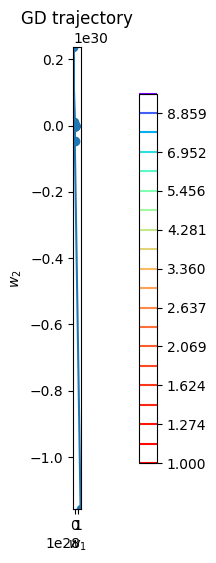

Learning Rate: 0.03727593720314938
Batch Size: 257
Current Loss Function Value: 3.594339799429303e+62


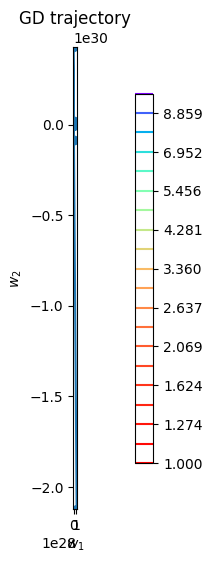

Learning Rate: 0.03727593720314938
Batch Size: 300
Current Loss Function Value: 1.8851706455120124e+62


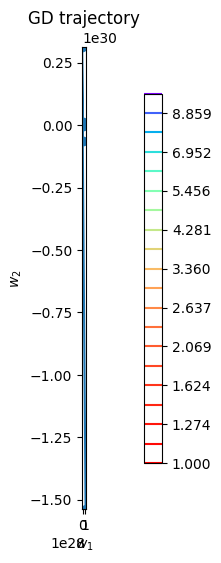

Learning Rate: 0.1
Batch Size: 1
Current Loss Function Value: 4.1449855211429576e+143


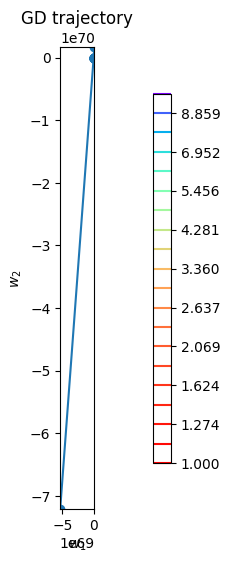

Learning Rate: 0.1
Batch Size: 43
Current Loss Function Value: 1.6290079998201904e+109


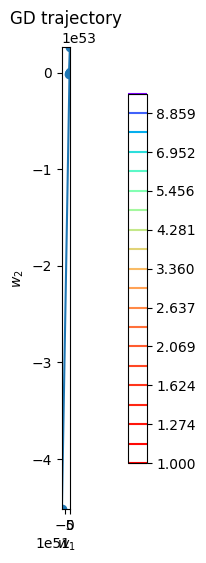

Learning Rate: 0.1
Batch Size: 86
Current Loss Function Value: 6.74119088944445e+108


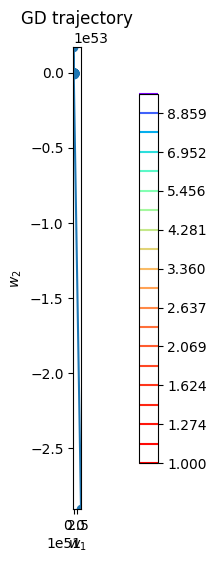

Learning Rate: 0.1
Batch Size: 129
Current Loss Function Value: 2.307405639125038e+104


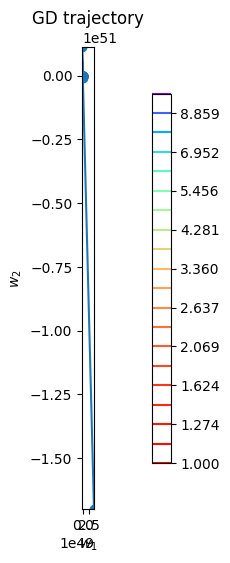

Learning Rate: 0.1
Batch Size: 171
Current Loss Function Value: 1.2029372864201033e+104


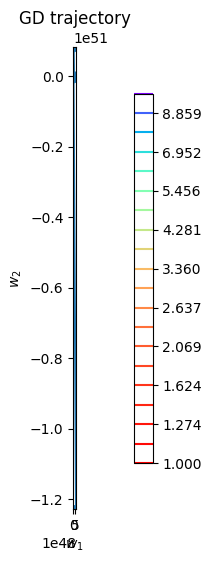

Learning Rate: 0.1
Batch Size: 214
Current Loss Function Value: 3.4349961150424754e+103


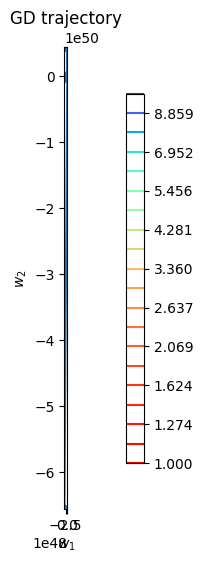

Learning Rate: 0.1
Batch Size: 257
Current Loss Function Value: 1.725626790345103e+104


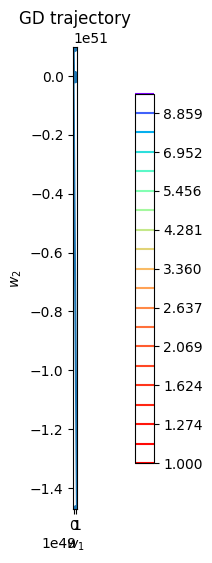

Learning Rate: 0.1
Batch Size: 300
Current Loss Function Value: 3.9534339479603e+103


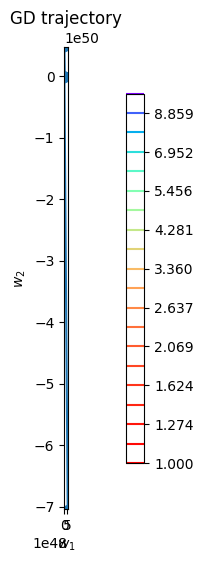

Best Learning Rate: 0.005179474679231213
Best Batch Size: 171


In [224]:
batch_array = np.linspace(1, 300, num=8, dtype=int)
learning_rate_array = np.geomspace(0.0001, 0.1, num=8)
min_loss, best_lr_bch = np.inf, None

for step in learning_rate_array:
    for bch in batch_array:
        w_list = stochastic_gradient_descent(w_init, X, y, loss, step, bch, num_steps)
        cur_loss = loss.calc_loss(X, y, w_list[-1])
        print(f'Learning Rate: {step}\nBatch Size: {bch}\nCurrent Loss Function Value: {cur_loss}')
        if cur_loss < min_loss:
            best_lr_bch, min_loss = (bch, step,), cur_loss
        plot_gd(w_list, X, y, loss)
print(f'Best Learning Rate: {best_lr_bch[1]}\nBest Batch Size: {best_lr_bch[0]}')

Лучший вариант с параметрами батча = 171 и шагом = 0.005. В целом, здесь также наблюдаем как кейсы, когда модель просто не дошла до локального минимума из-за слишком маленького шага, так и кейсы, где она их перепрыгивала из-за слишком большого шага. С батчем тренд аналогичный: маленький - переобучение, большой - теряется смысл в использовании, так как повторим классический градиентный спуск.

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага. 

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его. 

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [225]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = w_init.copy()
    w_list = [w.copy()]
    s_0 = 1
    batch_ind = np.random.choice(X.shape[0], size=batch_size, replace=False)
    batch, batch_y = X[batch_ind], y[batch_ind]
    for i in range(n_iterations):
        w_list.append(w.copy())
        step_size = lr * np.power(s_0 / (s_0 + i), p)
        w -= step_size * loss.calc_grad(batch, batch_y, w)
    return np.array(w_list)

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

P: 0.1
Loss Function Value: 1.1704681851901269


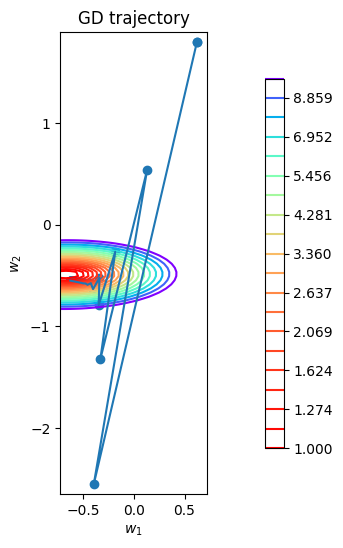

P: 0.2285714285714286
Loss Function Value: 0.9307297395894742


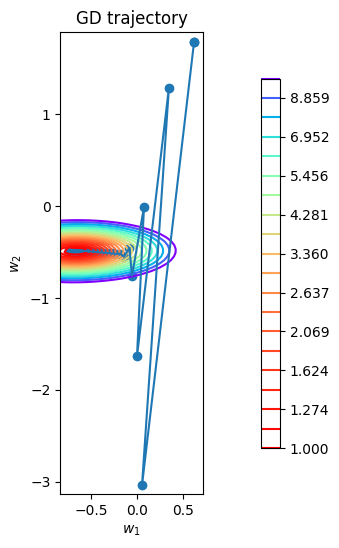

P: 0.3571428571428572
Loss Function Value: 0.9310197829048261


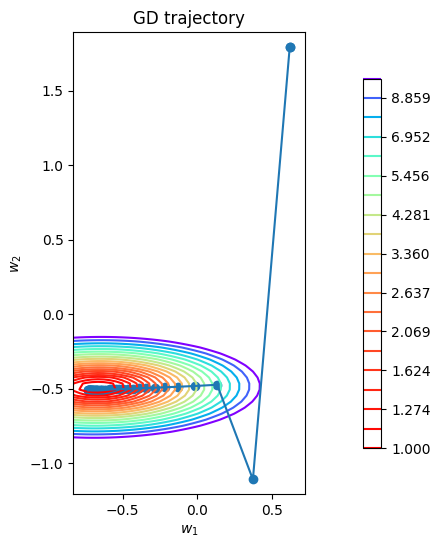

P: 0.48571428571428577
Loss Function Value: 1.4438535908803938


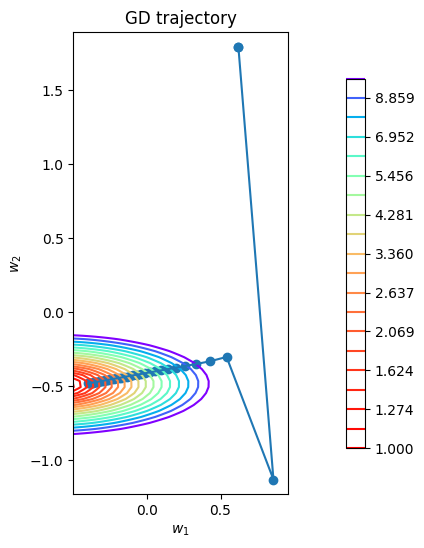

P: 0.6142857142857143
Loss Function Value: 3.2035029663580703


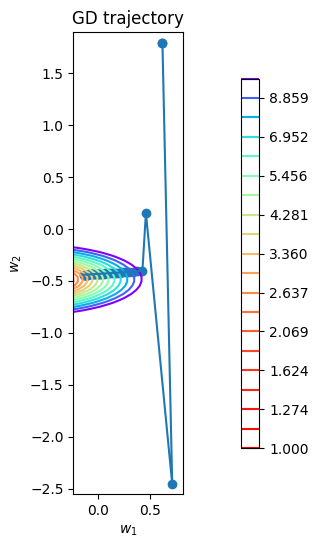

P: 0.7428571428571429
Loss Function Value: 2.4197221568977905


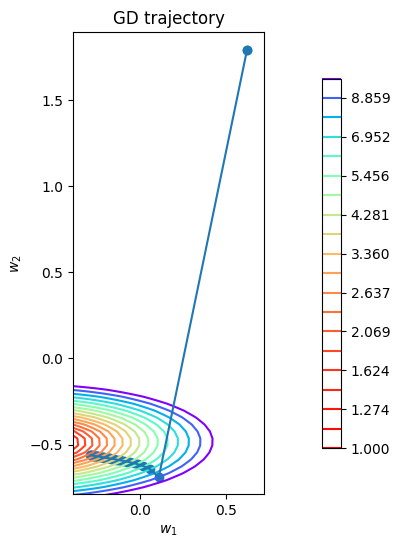

P: 0.8714285714285716
Loss Function Value: 1.7503092105040015


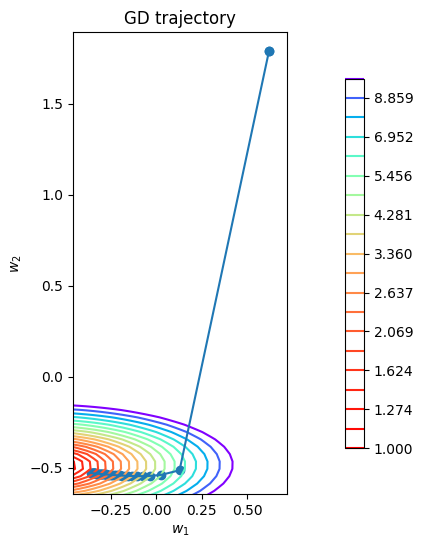

P: 1.0
Loss Function Value: 6.630652309267671


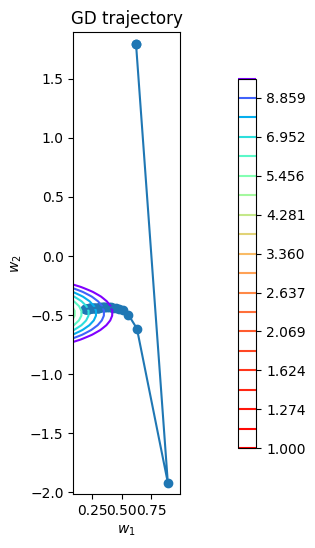

Best P: 1.0
Minimal Loss: 0.9307297395894742


In [226]:
p_list = np.linspace(0.1, 1, num=8)
lr = 0.01
bсh = 10
min_loss, best_p = np.inf, None

for p in p_list:
    w_list = stochastic_gradient_descent(w_init, X, y, loss, 
                                         lr, bсh, p, num_steps)
    cur_loss = loss.calc_loss(X, y, w_list[-1])
    print(f'P: {p}\nLoss Function Value: {cur_loss}')
    if cur_loss < min_loss:
        best_p, min_loss = p, cur_loss
    plot_gd(w_list, X, y, loss)
print(f'Best P: {p}\nMinimal Loss: {min_loss}')

Лучшим P оказался 1.0. С одной стороны хорошо, что первые шаги оказываются большими (дальше -- меньше), так можно быстрее достигнуть локального минимума, но с другой -- в каких-то ситуациях его можно и перешагнуть, что нам не нужно. Вывод: длину шага нужно подбирать (очевидно, но лучше повторить).

График данной функции при визуализации даёт гиперболу.
$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

На данном этапе меня интересует сравнение лучшего показателя P (который уже был подобран) при реализации стохастического градиентного спуска (чтобы было не зря) с классическим GD.

In [227]:
bсh, learning_rate_array, p = 10, 0.01, 1

w_list_gd = gradient_descent(w_init, X, y, loss, lr, num_steps)
w_list_sgd = stochastic_gradient_descent(w_init, X, y, loss, lr, bсh, p, num_steps)

loss_gd = [loss.calc_loss(X, y, weights) for weights in w_list_gd]
loss_sgd = [loss.calc_loss(X, y, weights) for weights in w_list_sgd]


nums = np.arange(0, num_steps + 1, 1)

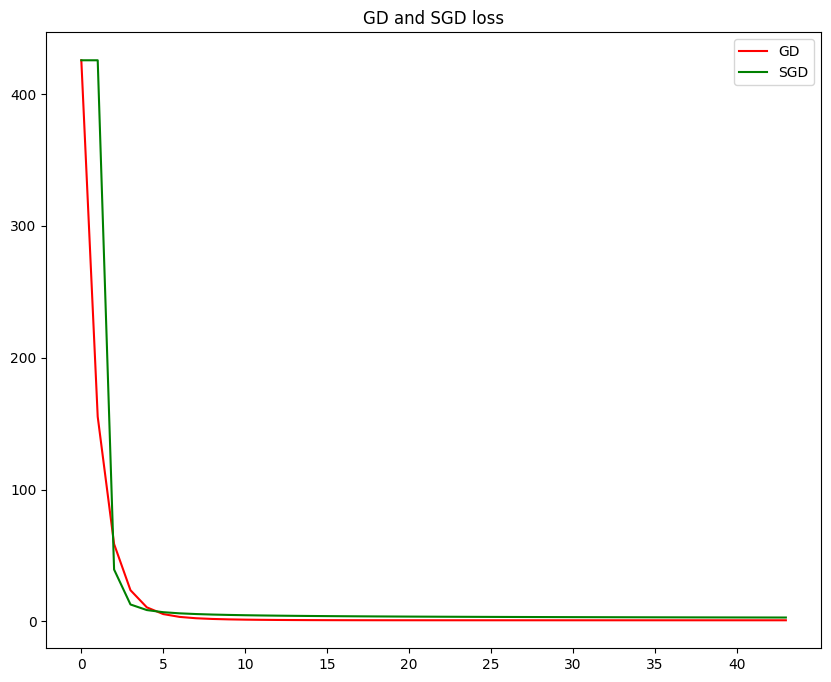

In [228]:
plt.figure(figsize=(10,8))
plt.title("GD and SGD loss")
plt.plot(nums, loss_gd, color='red', label='GD')
plt.plot(nums, loss_sgd, color='green', label='SGD')
plt.xticks(np.arange(0, 43, step=5))
plt.legend()
plt.show()

Значение функции потерь у GD немного меньше, но в случае с SGD за счёт меньшего количества шагов в теории можем выиграть по производительности, когда это действительно будет нужно (при обучении с большими массивами данных, например). Т.е. в целом SGD должен быстрее сходиться (на данном примере это тоже происходит). Но здесь я всё же отдам предпочтение GD. 

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [229]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        self.w = np.random.randn(X.shape[1])
        w_list = gradient_descent(self.w, X, y, self.loss, self.lr)
        self.w = w_list[-1]
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        return np.dot(X, self.w)

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [230]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [231]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [232]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)
X_raw = X_raw.drop(columns=['index'], axis=1) # выкинем лишний столбец с индексами
X_raw

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28
197,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25
198,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23
199,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27


**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [233]:
X_raw.columns = X_raw.columns.astype(str) # все колонки сделаем строками по типу, чтобы питон не ругался
# создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values

# для вещественнозначных признаков заполним пропуски средними арифметическим
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(
    data=mis_replacer.fit_transform(X_real), columns=X_real.columns
)

# для категориальных — пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna('')
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

In [234]:
# Преобразуем нечисловые признаки при помощи one-hot encoding

X_dum = pd.get_dummies(X_no_mis, drop_first=True)
print(f"Data shape: {X_dum.shape}")
X_dum.head()

Data shape: (201, 65)


,0,1,9,10,11,12,13,16,18,19,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,0,0,0,0,0,0,0,1,0,0
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0


In [235]:
from sklearn.model_selection import train_test_split
np.random.seed(666)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size = 0.33, random_state=666)

In [236]:
print(X_train.shape, y_train.shape)

(134, 65) (134,)


In [237]:
# Нормализуем данные с помощью MinMaxScaler. 
# Преобразование признаков путем масштабирования 
# каждого признака в заданном диапазоне (дефолтно 0, 1).

normalizer = MinMaxScaler()
X_train_transformed  = normalizer.fit_transform(X_train)
X_test_transformed  = normalizer.transform(X_test)

**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [238]:
linear_regression.fit(X_train_transformed, y_train)
preds_train = linear_regression.predict(X_train_transformed)
preds_test = linear_regression.predict(X_test_transformed)

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [239]:
print(f'Train MSE: {mse(preds_train, y_train)}')
print(f'Test MSE: {mse(preds_test, y_test)}')

Train MSE: 1286479.3722338085
Test MSE: 6651345.726714252


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [240]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # -- YOUR CODE HERE --
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        return np.square(np.dot(X, w) - y).mean() + (self.coef * np.linalg.norm(w[:-1]) ** 2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # -- YOUR CODE HERE --
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        w_t = w.copy()
        w_t[-1] = 0 # зануляем последний элемент
        return 2 * (np.dot(X.T, (np.dot(X, w) - y))) /  X.shape[0] + self.coef * 2 * w_t

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [241]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

In [242]:
cf_list = np.linspace(0, 1, num=15)
mn, best_cf = np.inf, None

for coef in cf_list:
    linear_regression = LinearRegression(MSEL2Loss(coef))
    linear_regression.fit(X_train_transformed, y_train)
    preds_test = linear_regression.predict(X_test_transformed)
    cur_mse = mse(preds_test, y_test)
    if cur_mse < mn:
        mn, best_cf = cur_mse, coef

print(f'Best Coefficient: {best_cf}')

linear_regression = LinearRegression(MSEL2Loss(best_cf))
linear_regression.fit(X_train_transformed, y_train)
preds_train = linear_regression.predict(X_train_transformed)
preds_test = linear_regression.predict(X_test_transformed)

print(f'Train MSE: {mse(preds_train, y_train)}')
print(f'Test MSE: {mse(preds_test, y_test)}')

# MSE_Loss
# Train MSE: 1286479.3548904231
# Test MSE: 6651339.129373738

Best Coefficient: 0.0
Train MSE: 1286479.3660881505
Test MSE: 6651330.727394727


Лучший коэффициент регуляризации = 0. Значит, никаких улучшений не произошло. Модель занулила норму весов, умножив на неё лучший коэффициент.

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [243]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        # -- YOUR CODE HERE --
        z = X.dot(w) - y
        sqared_part = np.square(z) / 2
        abs_part = np.abs(z) - self.eps / 2
        
        total_vec = np.zeros_like(y)
        total_vec[np.abs(z) < self.eps] = sqared_part[np.abs(z) < self.eps]
        total_vec[~(np.abs(z) < self.eps)] = abs_part[~(np.abs(z) < self.eps)]
        return total_vec.mean
        # Вычислите значение функции потерь при помощи X, y и w и верните его

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # -- YOUR CODE HERE --
        z = X.dot(w) - y
        lin_part = z
        sign_part = self.eps * np.sign(z)
        
        total_vec = np.zeros_like(y)
        total_vec[np.abs(z) < self.eps] = lin_part[np.abs(z) < self.eps]
        total_vec[~(np.abs(z) < self.eps)] = sign_part[~(np.abs(z) < self.eps)]
        return np.dot(X.T, total_vec) / X.shape[0]
        # Вычислите значение вектора градиента при помощи X, y и w и верните его

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [244]:
linear_regression = LinearRegression(HuberLoss(1))
linear_regression.fit(X_train_transformed, y_train)

preds_train = linear_regression.predict(X_train_transformed)
preds_test = linear_regression.predict(X_test_transformed)

mse_train = mse(preds_train, y_train_predicted)
mse_test = mse(preds_test, y_test_predicted)

print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')

# MSE_Loss
# Train MSE: 1286479.3548904231
# Test MSE: 6651339.129373738

Train MSE: 3.468345227518114
Test MSE: 3.208175879450318


In [ ]:
eps_list = np.linspace(25, 50, num=25)
min_loss, best_eps = np.inf, None

for epsilon in eps_list:
    linear_regression = LinearRegression(HuberLoss(epsilon))
    linear_regression.fit(X_train_transformed, y_train)
    
    preds_train = linear_regression.predict(X_train_transformed)
    preds_test = linear_regression.predict(X_test_transformed)
    test_mse = mse(preds_test, y_test)
    
    if test_mse < min_loss:
        min_loss, best_eps = test_mse, epsilon

linear_regression = LinearRegression(HuberLoss(best_eps))
linear_regression.fit(X_train_transformed, y_train)
preds_train = linear_regression.predict(X_train_transformed)
preds_test = linear_regression.predict(X_test_transformed)

print(f'Best Epsilon: {best_eps}')
print(f'Train MSE: {mse(preds_train, y_train)}')
print(f'Test MSE: {mse(preds_test, y_test)}')

Хубер в целом отработал лучше остальных кандидатов (Помним, что лучший коэффициент (0) в L2 занулил норму весов).

**Задание 3 (0.08/8 балла)**
Вставьте ваш любимый мем 2021 в ячейку ниже:

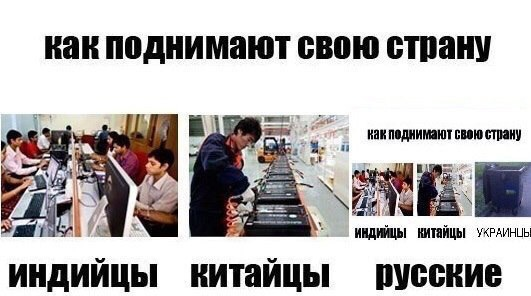

### БОНУС (2.5 баллов)

Градиентный спуск — далеко не единственный метод оптимизации. 
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2.5 баллов)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии. 

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределением с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [ ]:
def anneal_simulation(w_init, X, y, loss, t_max=1e+6, t_min=5): 
    def make_trans(d, t):
        prob = np.exp(-delta/t)
        val = random.uniform(0, 1)
        if val <= prob:
            return True
        return False
    
    
    t = t_max
    old_w = w_init.copy()
    w_list = [old_w.copy()]
    num = 1
    while t_min < t:
        new_w = old_w + np.random.standard_t(2, size=old_w.shape)
        delta = loss.calc_loss(X, y, new_w) - loss.calc_loss(X, y, old_w)
        if delta <= 0:
            old_w = new_w
        else:
            if make_trans(delta, t):
                old_w = new_w
        t = t_max * 0.1 / num
        num += 1
        w_list.append(old_w.copy())
    w_list = np.array(w_list)
    return w_list

In [ ]:
class LinearRegressionAnealDesc:
    def __init__(self, loss: BaseLoss, lr: float = 0.01) -> None:
        self.loss = loss
        self.lr = lr
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        X = np.asarray(X)
        y = np.asarray(y)
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        self.w = np.random.randn(X.shape[1])
        self.w_list_anneal = anneal_simulation(self.w, X, y, self.loss)
        self.w_list_gd = gradient_descent(self.w, X, y, self.loss, self.lr, 3000)
        self.w_ann = self.w_list_anneal[-1]
        self.w_gd = self.w_list_gd[-1]
        self.make_graph(X, y)
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        result_ann = np.dot(X, self.w_ann)
        result_gd = np.dot(X, self.w_gd)
        return {'ann': result_ann, 'gd': result_gd}
    
    def make_graph(self, X, y):
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        loss_ann = np.array([loss.calc_loss(X, y, weights) for weights in self.w_list_anneal])
        loss_gd = np.array([loss.calc_loss(X, y, weights) for weights in self.w_list_gd])
        n = len(loss_ann) - len(loss_gd)
        dums = np.full(n, None)
        loss_gd = np.concatenate([loss_gd, dums])
        nums = np.arange(0, len(loss_ann), 1)
        plt.figure(figsize=(10,8))
        plt.plot(nums, loss_ann, color='r', label='ANN')
        plt.plot(nums, loss_gd, color='g', label='GD')
        plt.title("GD and ANN loss")
        plt.xlabel('iterations')
        plt.legend()
        plt.show()

In [ ]:
%%time
linear_regression = LinearRegressionAnealDesc(MSELoss())
linear_regression.fit(X_train_transformed, y_train)
preds_train = linear_regression.predict(X_train_transformed)
preds_test = linear_regression.predict(X_test_transformed)

Как видно по графику -- данный алгоритм плохо себя показал. Классический градиентный спуск выдаёт сопоставимые результаты, но с гораздо меньшими затратами по времени.